# Event Recognition using Global Feature Descriptors and ML models

In [56]:
# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os

# fixed-sizes for image
fixed_size = tuple((500, 500))

# path to training data
train_path = 'C:/Users/Nivedha/Documents/widerdata/images'

bins=8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

In [57]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [58]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [59]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

['0 Parade', '1 Handshaking', '2 Demonstration', '3 Riot', '4 Cheering', '5 Shoppers', '6 Soccer']


In [60]:
global_features = []
labels = []

i, j = 0, 0
k = 0

In [61]:
# num of images per class
images_per_class = 210

In [62]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path + '/'+training_name)
    print(dir)

    # get the current training label
    current_label = training_name
    #print(current_label)

    k = 1
    # loop over the images in each sub-folder
    for x in os.listdir(dir):
        if x.endswith(".jpg"):
            file=x
            #print(file)
        
        # read the image and resize it to a fixed-size
        image = cv2.imread(dir + '/' + file)
        #print(file)
        #print(image)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram,fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print ("[STATUS] processed folder: {}".format(current_label))
    j += 1

print ("[STATUS] completed Global Feature Extraction...")

C:/Users/Nivedha/Documents/widerdata/images/0 Parade
[STATUS] processed folder: 0 Parade
C:/Users/Nivedha/Documents/widerdata/images/1 Handshaking
[STATUS] processed folder: 1 Handshaking
C:/Users/Nivedha/Documents/widerdata/images/2 Demonstration
[STATUS] processed folder: 2 Demonstration
C:/Users/Nivedha/Documents/widerdata/images/3 Riot
[STATUS] processed folder: 3 Riot
C:/Users/Nivedha/Documents/widerdata/images/4 Cheering
[STATUS] processed folder: 4 Cheering
C:/Users/Nivedha/Documents/widerdata/images/5 Shoppers
[STATUS] processed folder: 5 Shoppers
C:/Users/Nivedha/Documents/widerdata/images/6 Soccer
[STATUS] processed folder: 6 Soccer
[STATUS] completed Global Feature Extraction...


In [63]:
%%time
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] feature vector size (1470, 519)
[STATUS] training Labels (1470,)
Wall time: 269 ms


In [64]:
targetNames = np.unique(labels)
print(targetNames)
le = LabelEncoder()
target = le.fit_transform(labels)
print(target)
print ("[STATUS] training labels encoded...")

['0 Parade' '1 Handshaking' '2 Demonstration' '3 Riot' '4 Cheering'
 '5 Shoppers' '6 Soccer']
[0 0 0 ... 6 6 6]
[STATUS] training labels encoded...


In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler)
rescaled_features = scaler.fit_transform(global_features)
print(rescaled_features)
print ("[STATUS] feature vector normalized...")

MinMaxScaler(copy=True, feature_range=(0, 1))
[[0.02531944 0.04009829 0.05584592 ... 0.18223868 0.55593397 0.87204377]
 [0.00101001 0.03003087 0.01629862 ... 0.18224302 0.55601445 0.8720594 ]
 [0.01051208 0.03187769 0.05482447 ... 0.18223795 0.5562292  0.87204049]
 ...
 [0.00979233 0.03270757 0.02883201 ... 0.18223649 0.55583972 0.87203984]
 [0.0213524  0.02517336 0.0341021  ... 0.1822388  0.55588308 0.87204299]
 [0.00825527 0.01618598 0.02630441 ... 0.18223804 0.55590935 0.87204466]]
[STATUS] feature vector normalized...


In [66]:
print ("[STATUS] target labels: {}".format(target))
print ("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 6 6 6]
[STATUS] target labels shape: (1470,)


In [67]:
import h5py

In [68]:
h5f_data = h5py.File('C:/Users/Nivedha/Documents/Memorability/global_features.h5', 'w')
h5f_data.create_dataset('dataset_319', data=np.array(rescaled_features))

<HDF5 dataset "dataset_319": shape (1470, 519), type "<f8">

In [69]:
h5f_label = h5py.File('C:/Users/Nivedha/Documents/Memorability/labels.h5', 'w')
h5f_label.create_dataset('dataset_394', data=np.array(target))

<HDF5 dataset "dataset_394": shape (1470,), type "<i8">

In [70]:
h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] end of training..


In [71]:
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [72]:
num_trees = 100
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('C:/Users/Nivedha/Documents/Memorability/global_features.h5', 'r')
h5f_label = h5py.File('C:/Users/Nivedha/Documents/Memorability/labels.h5', 'r')

global_features_string = h5f_data['dataset_319']
global_labels_string = h5f_label['dataset_394']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (1470, 519)
[STATUS] labels shape: (1470,)
[STATUS] training started...


In [73]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1323, 519)
Test data   : (147, 519)
Train labels: (1323,)
Test labels : (147,)


LR: 0.392276 (0.032274)
LDA: 0.307576 (0.048943)
KNN: 0.310674 (0.016311)
CART: 0.288813 (0.053539)
RF: 0.419549 (0.032494)
NB: 0.269133 (0.045191)
SVM: 0.125467 (0.021683)


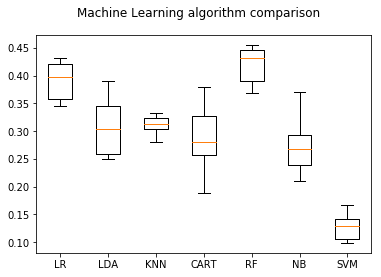

Wall time: 45.7 s


In [74]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Testing Process

In [75]:
tr_path = 'C:/Users/Nivedha/Documents/prediction3/images'

In [76]:
# get the training labels
tr_labels = os.listdir(tr_path)

# sort the training labels
tr_labels.sort()
print(tr_labels)

['0 Parade', '1 Handshaking', '2 Demonstration', '3 Riot', '4 Cheering', '5 Shoppers', '6 Soccer']


In [77]:
# get the training labels
tr_labels = os.listdir(tr_path)

# sort the training labels
tr_labels.sort()
print(tr_labels)

['0 Parade', '1 Handshaking', '2 Demonstration', '3 Riot', '4 Cheering', '5 Shoppers', '6 Soccer']


In [78]:
test_features = []
test_labels = []

In [79]:
# loop over the training data sub-folders
for tr_name in tr_labels:
    # join the training data path and each species training folder
    dir = os.path.join(tr_path + '/'+tr_name)
    print(dir)

    # get the current training label
    curr_label = tr_name
    #print(curr_label)

    k = 1
    # loop over the images in each sub-folder
    for x in os.listdir(dir):
        if x.endswith(".jpg"):
            file=x
            #print(file)
        
        # read the image and resize it to a fixed-size
        image = cv2.imread(dir + '/' + file)
        #print(file)
        #print(image)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        glo = np.hstack([fv_histogram,fv_hu_moments])

        # update the list of labels and feature vectors
        test_labels.append(curr_label)
        test_features.append(glo)

        i += 1
        k += 1
    print ("[STATUS] processed folder: {}".format(curr_label))
    j += 1

print ("[STATUS] completed Global Feature Extraction...")

C:/Users/Nivedha/Documents/prediction3/images/0 Parade
[STATUS] processed folder: 0 Parade
C:/Users/Nivedha/Documents/prediction3/images/1 Handshaking
[STATUS] processed folder: 1 Handshaking
C:/Users/Nivedha/Documents/prediction3/images/2 Demonstration
[STATUS] processed folder: 2 Demonstration
C:/Users/Nivedha/Documents/prediction3/images/3 Riot
[STATUS] processed folder: 3 Riot
C:/Users/Nivedha/Documents/prediction3/images/4 Cheering
[STATUS] processed folder: 4 Cheering
C:/Users/Nivedha/Documents/prediction3/images/5 Shoppers
[STATUS] processed folder: 5 Shoppers
C:/Users/Nivedha/Documents/prediction3/images/6 Soccer
[STATUS] processed folder: 6 Soccer
[STATUS] completed Global Feature Extraction...


In [80]:
%%time
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(test_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(test_labels).shape))

[STATUS] feature vector size (140, 519)
[STATUS] training Labels (140,)
Wall time: 2 ms


In [81]:
testNames = np.unique(test_labels)
print(testNames)
les = LabelEncoder()
test = les.fit_transform(test_labels)
print(test)
print ("[STATUS] training labels encoded...")

['0 Parade' '1 Handshaking' '2 Demonstration' '3 Riot' '4 Cheering'
 '5 Shoppers' '6 Soccer']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[STATUS] training labels encoded...


In [82]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
print(scaler1)
rescaledtest_features = scaler.transform(test_features)
print(rescaledtest_features)
print ("[STATUS] feature vector normalized...")

MinMaxScaler(copy=True, feature_range=(0, 1))
[[2.14107368e-03 2.16558973e-02 3.28608942e-02 ... 1.82238380e-01
  5.55857776e-01 8.72043823e-01]
 [1.04321057e-02 1.35949373e-02 2.41714159e-02 ... 1.82243746e-01
  5.55795537e-01 8.72034804e-01]
 [1.58507409e-02 5.36246548e-01 7.69445994e-02 ... 1.82238656e-01
  5.55893249e-01 8.72043111e-01]
 ...
 [9.47117910e-03 2.26273648e-02 2.67541652e-02 ... 1.82263758e-01
  5.55305877e-01 8.72033731e-01]
 [9.81544449e-01 1.32029292e-03 6.48239471e-05 ... 1.97232680e-01
  7.00599597e-01 8.69509962e-01]
 [1.45849043e-03 3.81047078e-03 1.65246885e-03 ... 1.82238723e-01
  5.55880591e-01 8.72043268e-01]]
[STATUS] feature vector normalized...


In [83]:
h5f_datatest = h5py.File('C:/Users/Nivedha/Documents/Memorability/test_features.h5', 'w')
h5f_datatest.create_dataset('dataset_030', data=np.array(rescaledtest_features))

<HDF5 dataset "dataset_030": shape (140, 519), type "<f8">

In [84]:
h5f_labeltest = h5py.File('C:/Users/Nivedha/Documents/Memorability/test_labels.h5', 'w')
h5f_labeltest.create_dataset('dataset_919', data=np.array(test))

<HDF5 dataset "dataset_919": shape (140,), type "<i8">

In [85]:
h5f_datatest.close()
h5f_labeltest.close()

print("[STATUS] end of training..")

[STATUS] end of training..


In [86]:
h5f_datatest = h5py.File('C:/Users/Nivedha/Documents/Memorability/test_features.h5', 'r')
h5f_labeltest = h5py.File('C:/Users/Nivedha/Documents/Memorability/test_labels.h5', 'r')

test_global_features_string = h5f_datatest['dataset_030']
test_global_labels_string = h5f_labeltest['dataset_919']

test_features = np.array(test_global_features_string)
test_global_labels = np.array(test_global_labels_string)

h5f_datatest.close()
h5f_labeltest.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(test_features.shape))
print ("[STATUS] labels shape: {}".format(test_global_labels.shape))

[STATUS] features shape: (140, 519)
[STATUS] labels shape: (140,)


In [88]:
test_data = np.array(test_features)
test_labels = np.array(test_global_labels)

In [89]:
for name, model in models:
    model.fit(trainDataGlobal, trainLabelsGlobal)

    ypred = model.predict(test_data)

    #print("\nLinear SVC Accuracy (Ten-Fold CV):", cross_val_score(model, features, labels, cv=10).mean(), "\n")

    print("Accuracy (Holdout Set):", accuracy_score(test_labels, ypred), "\n")

Accuracy (Holdout Set): 0.4 

Accuracy (Holdout Set): 0.30714285714285716 

Accuracy (Holdout Set): 0.29285714285714287 

Accuracy (Holdout Set): 0.29285714285714287 

Accuracy (Holdout Set): 0.5214285714285715 

Accuracy (Holdout Set): 0.2857142857142857 

Accuracy (Holdout Set): 0.14285714285714285 



In [90]:
model1= RandomForestClassifier(n_estimators=num_trees, random_state=9)
model1.fit(trainDataGlobal, trainLabelsGlobal)
ypred1 = model1.predict(test_data)

In [91]:
print(ypred1)

[0 6 5 5 0 0 5 0 2 1 0 2 2 2 0 2 5 5 0 2 1 1 3 1 6 1 1 1 1 1 4 4 1 1 1 1 1
 2 3 1 2 2 5 2 2 2 3 2 3 2 5 0 2 3 2 5 1 2 1 1 3 3 1 3 3 5 0 1 0 4 3 3 2 3
 3 3 3 2 1 3 4 6 3 6 6 6 6 4 3 5 0 3 4 5 2 4 1 4 6 5 3 4 5 0 5 4 5 2 2 4 2
 0 3 2 5 5 3 5 5 1 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [92]:
print(classification_report(test_labels, ypred1))

             precision    recall  f1-score   support

          0       0.50      0.35      0.41        20
          1       0.61      0.70      0.65        20
          2       0.42      0.50      0.45        20
          3       0.50      0.55      0.52        20
          4       0.45      0.25      0.32        20
          5       0.37      0.35      0.36        20
          6       0.70      0.95      0.81        20

avg / total       0.51      0.52      0.50       140



[INFO] confusion matrix


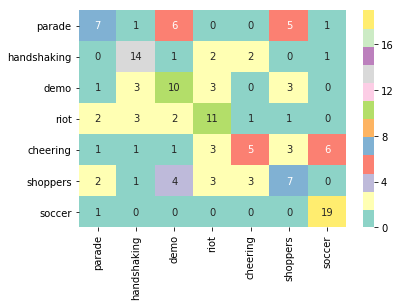

In [93]:
# display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
print ("[INFO] confusion matrix")

# get the list of training lables
labels = sorted(list(os.listdir(tr_path)))

# plot the confusion matrix
cm = confusion_matrix(test_labels, ypred1)
cm_df = pd.DataFrame(cm,
                     index = ['parade','handshaking','demo','riot','cheering','shoppers','soccer'], 
                     columns = ['parade','handshaking','demo','riot','cheering','shoppers','soccer'])
sns.heatmap(cm_df,
            annot=True,
            cmap="Set3")

plt.show()